In [2]:
import mediapy as media
import matplotlib.pyplot as plt
import jax
from tqdm import trange
from jax import numpy as jp

In [3]:
from rlg.experiments.walker.walker_robust import WalkerRobust


env = WalkerRobust(task_mode="body")

Warp DeprecationWarning: The namespace `warp.context` will soon be removed from the public API. It can still be accessed from `warp._src.context` but might be changed or removed without notice.
Warp DeprecationWarning: The symbol `warp.context.Module` will soon be removed from the public API. Use `warp.Module` instead.
Warp DeprecationWarning: The symbol `warp.context.get_module` will soon be removed from the public API. Use `warp.get_module` instead.
Warp DeprecationWarning: The namespace `warp.math` will soon be removed from the public API. It can still be accessed from `warp._src.math` but might be changed or removed without notice.


In [4]:
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from mujoco_playground.config import dm_control_suite_params

ppo_params = dm_control_suite_params.brax_ppo_config("WalkerWalk")
ppo_params

action_repeat: 1
batch_size: 1024
discounting: 0.995
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.001
normalize_observations: true
num_envs: 2048
num_evals: 10
num_minibatches: 32
num_resets_per_eval: 10
num_timesteps: 60000000
num_updates_per_batch: 16
reward_scaling: 10.0
unroll_length: 30

In [4]:
from rlg.experiments.walker.walker_robust import WalkerTaskParams


def sample_task(rng: jax.Array) -> WalkerTaskParams:
    """Samples task parameters from the RoML distribution.

    Distribution: log2(tau) ~ U([-1, 1]) for each parameter.
    Returns:
        jax.Array: [mass_scale, size_scale, damping_scale]
    """
    # Sample 3 independent log-uniform factors
    log_taus = jax.random.uniform(rng, shape=(3,), minval=-1.0, maxval=1.0)
    taus = 2.0**log_taus

    # "body" mode: vary mass, size (head), and damping
    return WalkerTaskParams(
        mass_scale=taus[0], size_scale=taus[1], damping_scale=taus[2]
    )

In [5]:

import contextlib
import functools
from typing import Any, Callable, List, Optional, Sequence, Tuple

from brax.envs.wrappers import training as brax_training
import jax
from jax import numpy as jp
import mujoco
from mujoco import mjx
from mujoco_playground._src import mjx_env
from mujoco_playground._src.wrapper import BraxAutoResetWrapper
import numpy as np

from rlg.experiments.walker.brax_multi_task_wrapper import BraxMultiTaskWrapper


def multi_task_wrapper(
    env: mjx_env.MjxEnv,
    episode_length: int = 1000,
    action_repeat: int = 1,
    vision: bool = False,
    num_vision_envs: int = 1,
    randomization_fn: Optional[
        Callable[[mjx.Model], Tuple[mjx.Model, mjx.Model]]
    ] = None,
    full_reset: bool = True,
):
  env = BraxMultiTaskWrapper(env, task_sampler=sample_task)
  env = brax_training.VmapWrapper(env)
  env = brax_training.EpisodeWrapper(env, episode_length, action_repeat)
  env = BraxAutoResetWrapper(env, full_reset=True)  # full reset for multi-task
  return env

In [6]:
from datetime import datetime
from IPython.display import HTML, clear_output

x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress,
    run_evals=True
)

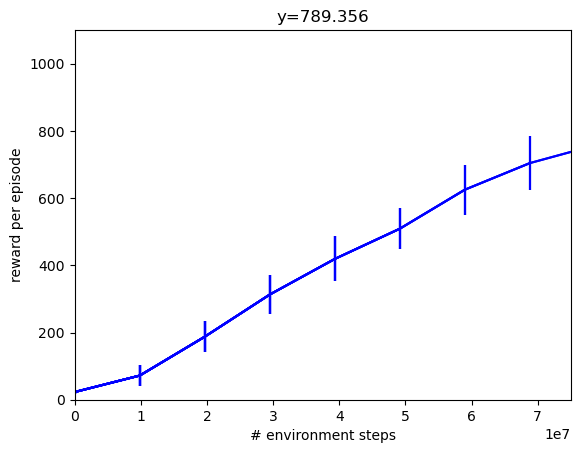

time to jit: 0:00:57.457522
time to train: 0:11:09.096250


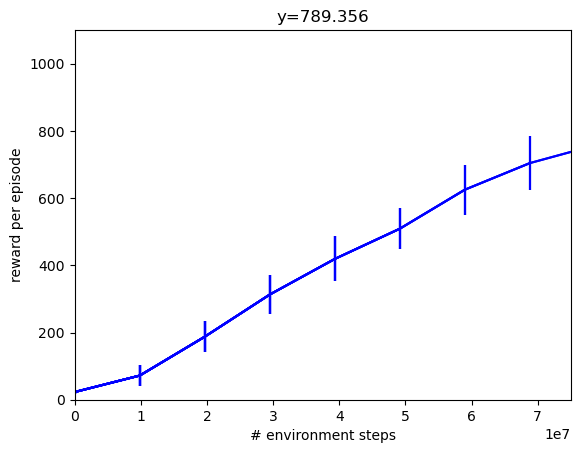

In [7]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=multi_task_wrapper,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [8]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
# jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))
task = WalkerTaskParams(
    mass_scale=jp.array(1.0),
    size_scale=jp.array(3.0),
    damping_scale=jp.array(1.0),
)

NameError: name 'WalkerTaskParams' is not defined

In [ ]:

rng = jax.random.PRNGKey(42)
rollout = []

state = jit_reset(rng, task_params=task)
rollout.append(state)
for i in trange(1000):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

rewards = [s.reward for s in rollout]
print(f"Total reward: {np.sum(rewards)}")

100%|██████████| 1000/1000 [00:08<00:00, 116.33it/s]


Total reward: 811.3218994140625


In [1]:
render_every = 1
frames = env.render(task, rollout[::render_every], camera="side")
media.show_video(frames, fps=1.0 / env.dt / render_every)

NameError: name 'env' is not defined

In [29]:
import orbax.checkpoint as ocp
from pathlib import Path

checkpointer = ocp.StandardCheckpointer()
path = Path("walker_run")
checkpointer.save(path.absolute(), params)

In [6]:
re_state = env.reset(jax.random.key(0), task_params=task)

NameError: name 'task' is not defined

In [5]:
ppo_networks.make_ppo_networks()

TypeError: make_ppo_networks() missing 2 required positional arguments: 'observation_size' and 'action_size'